# Dataset

The dataset 

In [1]:
#import packages and verify versions

!pip install wordcloud
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# nltk
import nltk
print('nltk: %s' % nltk.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)
# wordcloud
import wordcloud
print('wordcloud: %s' % wordcloud.__version__)
# keras
import keras
print('keras: %s' % keras.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)#import packages and verify versions

!pip install wordcloud
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# nltk
import nltk
print('nltk: %s' % nltk.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)
# wordcloud
import wordcloud
print('wordcloud: %s' % wordcloud.__version__)
# keras
import keras
print('keras: %s' % keras.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
numpy: 1.22.4
scipy: 1.10.1
matplotlib: 3.7.1
pandas: 1.4.4
nltk: 3.8.1
sklearn: 1.2.2
wordcloud: 1.8.2.2
keras: 2.12.0
tensorflow: 2.12.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
numpy: 1.22.4
scipy: 1.10.1
matplotlib: 3.7.1
pandas: 1.4.4
nltk: 3.8.1
sklearn: 1.2.2
wordcloud: 1.8.2.2
keras: 2.12.0
tensorflow: 2.12.0


In [2]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import time
import matplotlib.pyplot as plt



# Packages for data preparation
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

# Word cloud visualization libraries
#from scipy.misc import imresize
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from collections import Counter

import itertools

from keras.wrappers.scikit_learn import KerasClassifier

# Packages for Sequence and CNN based layers
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.models import Sequential, Model, load_model
#from keras.layers.embeddings import Embedding
from keras.layers import Embedding
from keras.layers import Flatten, Dense, Dropout, AlphaDropout, ThresholdedReLU, Convolution1D, ZeroPadding1D, Activation, MaxPooling1D, SpatialDropout1D, Input 
from keras.layers import GlobalMaxPooling1D, concatenate, LSTM, Bidirectional,BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard



In [3]:
# location of data
DATA_FILE = '/content/drive/MyDrive/5. PROJECTS/sentiment-analysis-cnn/data/Tweets.csv'

# data columns for learning
TEXT_COLUMN_NAME = 'text'
LABEL_COLUMN_NAME = 'airline_sentiment'

# EMBEDDINGS FILE 
GLOVE_EMBEDDINGS_FILE = '/content/drive/MyDrive/5. PROJECTS/sentiment-analysis-cnn/data/embeddings/glove.6B.100d.txt'
FASTTEXT_EMBEDDINGS_FILE = '/content/drive/MyDrive/5. PROJECTS/sentiment-analysis-cnn/data/embeddings/wiki-news-300d-1M.vec'

# parameters for learning
# Parameter indicating the number of words we'll put in the dictionary
# (change it per source)
NB_WORDS = 10000
VAL_SIZE = 1000  # Size of the validation set
NB_EPOCHS = 20  # Number of epochs
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
# Maximum number of words in a sequence (see the sentence distribution)
MAX_LEN = 24
EMBEDDING_DIM = 100  # Number of dimensions of the GloVe word embeddings
FASTTEXT_EMBEDDING_DIM = 300  # Number of dimensions of the FastText word embeddings
MAX_SENT_LEN = 300  # character based length
MAX_DOC_LEN = 5  # Number of sentences in text

# labels
labels = ['negative', 'neutral', 'positive']

# 1. Exploratory Data Analysis

### 1.1 Loading the data in Pandas Dataframe

In [4]:
# read the file
tweets = pd.read_csv(DATA_FILE)
tweets = tweets.reindex(np.random.permutation(tweets.index))

# only the text and labels
tweets = tweets[[TEXT_COLUMN_NAME, LABEL_COLUMN_NAME]]

# get a peek of the data
tweets.head()

,text,airline_sentiment
4163,@united I am furious. You're firm is a disgra...,negative
9353,@USAirways look out for flying rocks this time...,positive
9469,@USAirways takes my money at once but then req...,negative
12397,@AmericanAir as your flight attendants are an ...,negative
7958,@JetBlue Love you guys sooooooo much. Ridiculo...,positive


### 1.2 Target distribution analysis

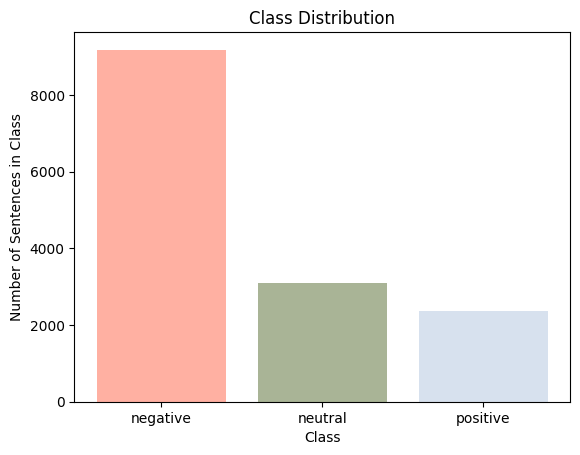

In [5]:
text = tweets[TEXT_COLUMN_NAME]
sentiments = tweets[LABEL_COLUMN_NAME]

# unique labels
sentiments.unique()

# group by
grouped = tweets.groupby([LABEL_COLUMN_NAME])[TEXT_COLUMN_NAME].count()
plt.bar(
    labels,
    grouped.values,
    align='center',
    color=[
        'tomato',
        'darkolivegreen',
        'lightsteelblue'],
    alpha=0.5)
plt.ylabel('Number of Sentences in Class')
plt.xlabel('Class')
plt.title('Class Distribution')

plt.show()

### 1.3 Text Length Frequency per Class

<function matplotlib.pyplot.show(close=None, block=None)>

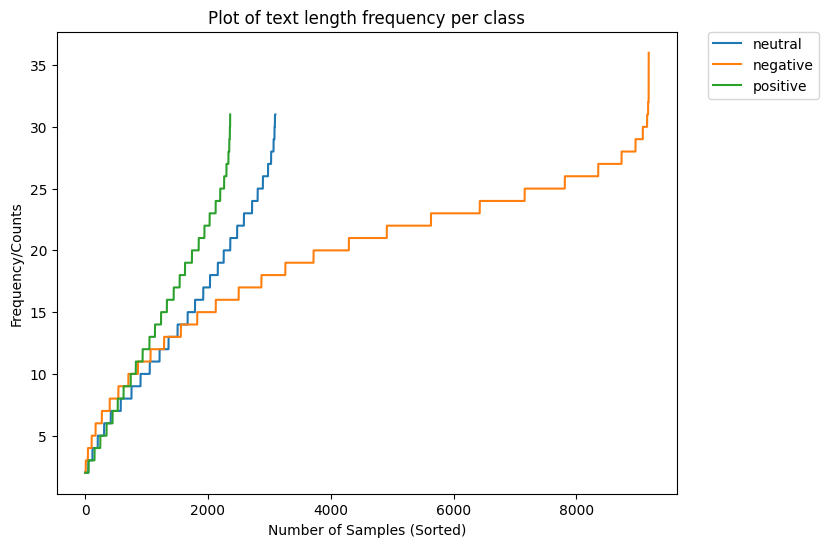

In [6]:
# set of unique label
lbl_set = list(set(sentiments))

def length_counter(all_label, all_text, class_name):
    class_txt = []

    # Seperate all lines for a class
    for lbl, txt in zip(all_label, all_text):
        if lbl == class_name:
            class_txt.append(txt)

     # Count words per line of that class
    line_word_count = []
    for k in range(len(class_txt)):
        line_words = class_txt[k].lower().split()
        line_word_count.append(len(line_words))

    return np.sort(line_word_count)


plt.figure(figsize=[8, 6])
for lbl in lbl_set:
    count = length_counter(sentiments, text, lbl)
    plt.plot(np.arange(1, len(count) + 1, 1), count, label=lbl)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Plot of text length frequency per class")
plt.xlabel("Number of Samples (Sorted)")
plt.ylabel("Frequency/Counts")
plt.show

### 1.4 Number of Words distribution

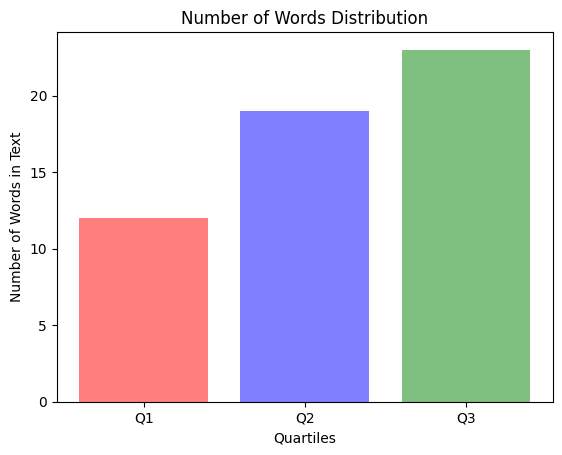

In [7]:
# ADD WORDS DERIVED COLUMN
NUMBER_OF_WORDS_COLUMN = TEXT_COLUMN_NAME + 'NB_WORDS_COLUM'
tweets[NUMBER_OF_WORDS_COLUMN] = tweets[TEXT_COLUMN_NAME].str.split().apply(len)
data = tweets[NUMBER_OF_WORDS_COLUMN].describe()

quartiles = ['Q1', 'Q2', 'Q3']
top = [data['25%'], data['50%'], data['75%']]
plt.bar(
    quartiles,
    top,
    align='center',
    color=[
        'red',
        'blue',
        'green'],
    alpha=0.5)
plt.ylabel('Number of Words in Text')
plt.xlabel('Quartiles')
plt.title('Number of Words Distribution')

plt.show()

### 1.4 Word Cloud for Positive and Negative Sentiments

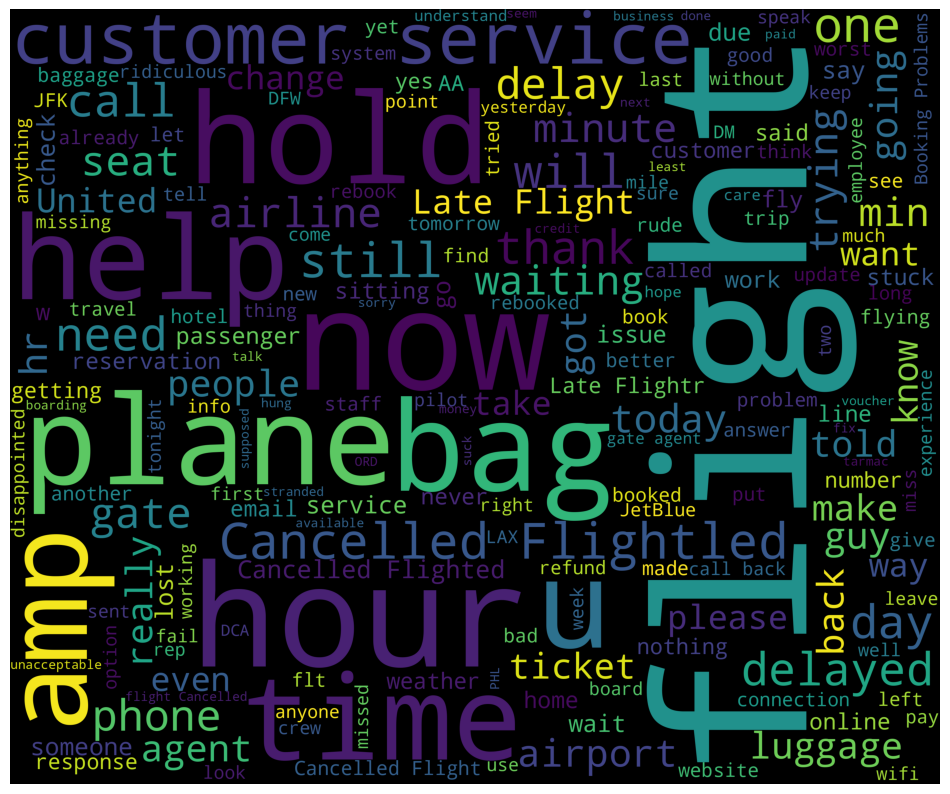

In [8]:
negative_df = tweets[tweets[LABEL_COLUMN_NAME] == 'negative']
words = ' '.join(negative_df[TEXT_COLUMN_NAME])
negative_cleaned_words = " ".join([word for word in words.split()
                                   if 'http' not in word
                                   and not word.startswith('@')
                                   and word != 'RT'
                                   ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                      ).generate(negative_cleaned_words)
plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

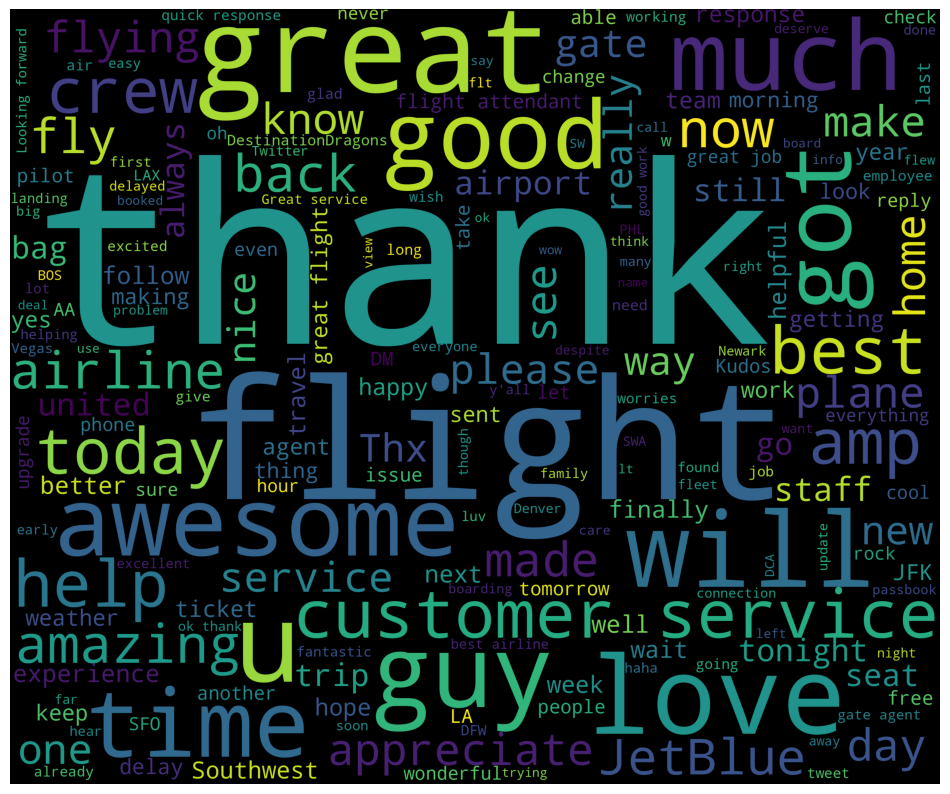

In [9]:
positive_df = tweets[tweets[LABEL_COLUMN_NAME] == 'positive']
all_positive_words = ' '.join(positive_df[TEXT_COLUMN_NAME])
positive_cleaned_words = " ".join([word for word in all_positive_words.split()
                                   if 'http' not in word
                                   and not word.startswith('@')
                                   and word != 'RT'
                                   ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                      ).generate(positive_cleaned_words)
plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 2. Data Preprocessing
### 2.1 Stopwords and mentions removal

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
# remove stop words with exceptions
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept
    white_list = ["n't", "not", "no"]
    words = input_text.split()
    clean_words = [word for word in words if (
        word not in stopwords_list or word in white_list) and len(word) > 1]
    return " ".join(clean_words)
# remove mentions


def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)


tweets = tweets[[TEXT_COLUMN_NAME, LABEL_COLUMN_NAME]]
tweets[TEXT_COLUMN_NAME] = tweets[TEXT_COLUMN_NAME].apply(
    remove_stopwords).apply(remove_mentions)
tweets.head()

,text,airline_sentiment
4163,furious. You're firm disgrace. Despite effort...,negative
9353,look flying rocks time! It's bird plane! Nah ...,positive
9469,takes money requires 10 days process refund? ...,negative
12397,flight attendants extension brand bitchy flig...,negative
7958,Love guys sooooooo much. Ridiculously appreci...,positive


## 2.2 Split dataset into Training and Testing (unseen)

In [12]:
X_train_entire, X_test, y_train_entire, y_test = train_test_split(
    tweets[TEXT_COLUMN_NAME], tweets[LABEL_COLUMN_NAME], test_size=0.15, random_state=37)
print('# Train data samples:', X_train_entire.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train_entire.shape[0] == y_train_entire.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 12444
# Test data samples: 2196


## 2.3 Tokenize the dataset on training data

In [13]:
# tokenization with max words defined and filters
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train_entire)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))

Fitted tokenizer on 12444 documents
10000 words in dictionary


## 2.4 Sentence distribution in training data

In [14]:
# understand the sequence distribution for max length 
seq_lengths = X_train_entire.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    12444.000000
mean        11.170926
std          4.218967
min          1.000000
25%          8.000000
50%         12.000000
75%         14.000000
max         24.000000
Name: text, dtype: float64

## 2.5 Convert Train and Test to fixed length sequences

In [15]:
# convert train and test to sequence using the tokenizer
X_train_entire_seq_tok = tk.texts_to_sequences(X_train_entire)
X_test_seq_tok = tk.texts_to_sequences(X_test)

# pad the sequences 
X_train_entire_seq = pad_sequences(X_train_entire_seq_tok, maxlen=MAX_LEN)
X_test_seq = pad_sequences(X_test_seq_tok, maxlen=MAX_LEN)

# perform encoding of 
le = LabelEncoder()
y_train_le = le.fit_transform(y_train_entire)
y_test_le = le.transform(y_test)
y_train_one_hot = to_categorical(y_train_le)
y_test_one_hot = to_categorical(y_test_le)


# labels from encoder mapping 
TARGET_TEXT_LABELS = le.classes_
TEXT_LABELS = le.classes_

### 2.6 Validation Dataset from Training

In [16]:
X_train_seq, X_valid_seq, y_train, y_valid = train_test_split(
    X_train_entire_seq, y_train_one_hot, test_size=0.15, random_state=37)

assert X_valid_seq.shape[0] == y_valid.shape[0]
assert X_train_seq.shape[0] == y_train.shape[0]

print('Shape of training set:', X_train_seq.shape)
print('Shape of validation set:', X_valid_seq.shape)

Shape of training set: (10577, 24)
Shape of validation set: (1867, 24)


## Model Building

### 3.1 Utilities for training, loging and testing

In [17]:
def get_predictions_and_confidences(model, X_test, y_test):
    """
    return the predictions and confidences on the test set
    :param model: the Keras Classifier Model
    :param X_test: test sequences
    :param y_test: labels
    :return: a list of actual labels
    """
    y_softmax = model.predict(X_test)
    y_class_index = []
    y_pred_index = []
    confidence = []

    for i in range(len(y_test)):
        probs = y_test[i]
        index_arr = np.nonzero(probs)
        one_hot_index = index_arr[0].item(0)
        y_class_index.append(one_hot_index)

    for i in range(0, len(y_softmax)):
        probs = y_softmax[i]
        predicted_index = np.argmax(probs)
        y_pred_index.append(predicted_index)
        confidence.append(probs[predicted_index])
    return y_class_index, y_pred_index, confidence, y_softmax

In [18]:
def train_model(model, X_train, y_train, X_valid, y_valid):
    """
    This function trains the deep model using the training set and valdiation set.

    :param model: the Keras Classifier Model
    :param X_train: train sequences
    :param y_train: trian labels
    :return: a list of actual labels

    """
    start = time.time()
    checkpoints = []
    model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    checkpoint_file = '/content/drive/MyDrive/5. PROJECTS/sentiment-analysis-cnn/models/checkpoints/Train-' + model.name + '-best_weights.h5'
    checkpoints.append(
        ModelCheckpoint(
            checkpoint_file,
            monitor='val_loss',
            verbose=0,
            save_best_only=True,
            save_weights_only=True,
            mode='auto',
            period=1))
    checkpoints.append(
        TensorBoard(
            log_dir='./logs',
            histogram_freq=0,
            write_graph=True,
            write_images=False,
            embeddings_freq=0,
            embeddings_layer_names=None,
            embeddings_metadata=None))
    checkpoints.append(EarlyStopping(monitor='val_loss', patience=10))

    history = model.fit(
        X_train,
        y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(
            X_valid,
            y_valid),
        verbose=1,
        callbacks=checkpoints)
    # load the weights from the checkpoint file, the best weights
    model.load_weights(checkpoint_file)
    end = time.time()
    total_time = end - start
    print("Model Training and Validation time %s secs" % (total_time))
    return history

In [19]:
def eval_metric(history, metric_name):

    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_EPOCHS + 1)

    plt.plot(e, metric, color='navy', label='Train ' + metric_name)
    plt.plot(e, val_metric, color='red', label='Validation ' + metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

# This utility function is from the sklearn docs:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def test_model(model, X_test, y_test):
    start = time.time()
    # checkpoint
    checkpoint_file = '/content/drive/MyDrive/5. PROJECTS/sentiment-analysis-cnn/models/checkpoints/Train-' + model.name + '-best_weights.h5'
    model.load_weights(checkpoint_file)
    results = model.evaluate(X_test, y_test)
    end = time.time()
    y_class_index, y_pred_index, confidence, y_softmax = get_predictions_and_confidences(
        model, X_test, y_test)
    cnf_matrix = confusion_matrix(y_class_index, y_pred_index)
    plt.figure(figsize=(6, 5))
    plot_confusion_matrix(
        cnf_matrix,
        classes=TEXT_LABELS,
        title="Confusion matrix")
    plt.show()
    total_time = end - start
    print("Model Training and Testing time : %s secs" % (total_time))
    print("Model Testing Accuracy : %s " % (results[1]))
    average_precision = average_precision_score(
        y_test, y_softmax, average='weighted')
    print('Average precision score: {0:0.2f}'.format(
        average_precision))
    return results


def test_model_runs(
        model,
        X_train,
        y_train,
        X_test,
        y_test,
        epoch_stop=20,
        num_runs=3,
        verbose=0):

    sum_result = 0
    sq_sum_result = 0
    for val in range(0, num_runs):
        base_results = test_model(
            model,
            X_train,
            y_train,
            X_test,
            y_test,
            epoch_stop,
            verbose)
        sum_result = sum_result + base_results[1]
        sq_sum_result = sq_sum_result + base_results[1] * base_results[1]
    mean_accuracy = sum_result / num_runs
    variance = sq_sum_result / num_runs - mean_accuracy * mean_accuracy
    stddev = variance**(.5)
    return mean_accuracy, stddev


def compare_loss(history, base_history, model_name, base_history_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = history.history['val_loss']

    e = range(1, NB_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label=base_history_name)
    plt.plot(e, loss_model, 'red', label=model_name)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.show()


def read_embedding(path):

    embeddings_index = {}
    f = open(path)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    return embeddings_index


def create_embedding_matrix(tokenizer, embedding_dim, embeddings_index):

    word_index = tokenizer.word_index
    if tokenizer.num_words:  # if num words is set, get rid of words with too high index
        word_index = {key: word_index[key] for key in word_index.keys()
                      if word_index[key] < (tokenizer.num_words + 1)}
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

## 3.2 Experiments

### 3.2.1 Experiment 1 - Basic CNN Block Experiment: 
A basic single block of CNN with convolution with filter of size 3, max pooling and a softmax layer

In [20]:
# base cnn model
def base_cnn_model():
    model = Sequential(
        [
            Embedding(
                input_dim=NB_WORDS,
                output_dim=EMBEDDING_DIM,
                input_length=MAX_LEN),
            Convolution1D(
                filters=64,
                kernel_size=3,
                padding='same',
                activation='relu'),
            MaxPooling1D(),
            Flatten(),
            Dense(
                100,
                activation='relu'),
            Dense(
                3,
                activation='softmax')])
    model._name = 'BaseCNN'
    model.summary()
    return model


# train and validate
base_cnn_model = base_cnn_model()
base_history = train_model(
    base_cnn_model,
    X_train_seq,
    y_train,
    X_valid_seq,
    y_valid)
# train the entire training data and test on test data on base model
test_model(base_cnn_model, X_test_seq, y_test_one_hot)

Model: "BaseCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 24, 100)           1000000   
                                                                 
 conv1d (Conv1D)             (None, 24, 64)            19264     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 100)               76900     
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                           

Epoch 1/20
21/21 [==============================] - 4s 141ms/step - loss: 0.9195 - accuracy: 0.6077 - val_loss: 0.8207 - val_accuracy: 0.6358
Epoch 2/20
21/21 [==============================] - 2s 121ms/step - loss: 0.7431 - accuracy: 0.6334 - val_loss: 0.7004 - val_accuracy: 0.6674
Epoch 3/20
21/21 [==============================] - 3s 139ms/step - loss: 0.6075 - accuracy: 0.7113 - val_loss: 0.6516 - val_accuracy: 0.7043
Epoch 4/20
21/21 [==============================] - 2s 78ms/step - loss: 0.4971 - accuracy: 0.7770 - val_loss: 0.6364 - val_accuracy: 0.7247
Epoch 5/20
21/21 [==============================] - 2s 79ms/step - loss: 0.3394 - accuracy: 0.8792 - val_loss: 0.6311 - val_accuracy: 0.7766
Epoch 6/20
21/21 [==============================] - 2s 77ms/step - loss: 0.2041 - accuracy: 0.9358 - val_loss: 0.6822 - val_accuracy: 0.7766
Epoch 7/20
21/21 [==============================] - 2s 76ms/step - loss: 0.1292 - accuracy: 0.9596 - val_loss: 0.7581 - val_accuracy: 0.7718
Epoch 8/20

KeyboardInterrupt: ignored

### 3.2.2 Experiment 2 - Basic CNN + Dropout
To see the impact of dropout on the base CNN

In [21]:
# CNN with dropout of 0.2
def base_cnn_dropout_model():
    model = Sequential(
        [
            Embedding(
                input_dim=NB_WORDS,
                output_dim=EMBEDDING_DIM,
                input_length=MAX_LEN),
            Convolution1D(
                filters=64,
                kernel_size=3,
                padding='same',
                activation='relu'),
            MaxPooling1D(),
            Flatten(),
            Dropout(0.2),
            Dense(
                100,
                activation='relu'),
            Dropout(0.2),
            Dense(
                3,
                activation='softmax')])
    model._name = 'BaseCNNWithDropouts'
    model.summary()
    return model

# train and validate
base_cnn_dropout_model = base_cnn_dropout_model()
base_cnn_dropout_history = train_model(
    base_cnn_dropout_model,
    X_train_seq,
    y_train,
    X_valid_seq,
    y_valid)
# train the entire training data and test on test data on base model
test_model(base_cnn_dropout_model, X_test_seq, y_test_one_hot)

Model: "BaseCNNWithDropouts"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 24, 100)           1000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 64)            19264     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 12, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               76900     
                                               

Epoch 1/20
21/21 [==============================] - 4s 147ms/step - loss: 0.9358 - accuracy: 0.6129 - val_loss: 0.8398 - val_accuracy: 0.6358
Epoch 2/20
 4/21 [====>.........................] - ETA: 2s - loss: 0.8332 - accuracy: 0.6216

KeyboardInterrupt: ignored

### 3.2.3 Experiment 3 - Base CNN with Regularization
To see the impact of L2 regularization on the base CNN.

In [ ]:
# regularization with l2 regularizer
def base_cnn_regularization_model():
    model = Sequential(
        [
            Embedding(
                input_dim=NB_WORDS,
                output_dim=EMBEDDING_DIM,
                input_length=MAX_LEN),
            Convolution1D(
                filters=64,
                kernel_size=3,
                padding='same',
                activation='relu'),
            MaxPooling1D(),
            Flatten(),
            Dense(
                100,
                kernel_regularizer=regularizers.l2(0.001),
                activation='relu'),
            Dense(
                3,
                activation='softmax')])
    model._name = 'BaseCNNWithRegularization'
    model.summary()
    return model


# train and validate
base_cnn_regularization_model = base_cnn_regularization_model()
base_cnn_regularization_history = train_model(
    base_cnn_regularization_model,
    X_train_seq,
    y_train,
    X_valid_seq,
    y_valid)
# test the models
test_model(base_cnn_regularization_model, X_test_seq, y_test_one_hot)

Model: "BaseCNNWithRegularization"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 24, 100)           1000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 24, 64)            19264     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 12, 64)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               76900     
                                                                 
 dense_5 (Dense)             (None, 3)                 303       
                                         

Epoch 1/20
21/21 [==============================] - 6s 256ms/step - loss: 1.0627 - accuracy: 0.6180 - val_loss: 0.9290 - val_accuracy: 0.6358
Epoch 2/20
21/21 [==============================] - 4s 167ms/step - loss: 0.8313 - accuracy: 0.6453 - val_loss: 0.7727 - val_accuracy: 0.6877
Epoch 3/20
21/21 [==============================] - 3s 156ms/step - loss: 0.6660 - accuracy: 0.7221 - val_loss: 0.7054 - val_accuracy: 0.7129
Epoch 4/20
21/21 [==============================] - 3s 168ms/step - loss: 0.5246 - accuracy: 0.7877 - val_loss: 0.6997 - val_accuracy: 0.7183
Epoch 5/20
21/21 [==============================] - 7s 332ms/step - loss: 0.3997 - accuracy: 0.8674 - val_loss: 0.7307 - val_accuracy: 0.7542
Epoch 6/20
21/21 [==============================] - 4s 167ms/step - loss: 0.2906 - accuracy: 0.9178 - val_loss: 0.7639 - val_accuracy: 0.7665
Epoch 7/20
21/21 [==============================] - 4s 178ms/step - loss: 0.2132 - accuracy: 0.9494 - val_loss: 0.7813 - val_accuracy: 0.7702
Epoch 

### 3.2.4 Multi-layer and Multi-filter CNN
To see the impact of adding more filters [2,3,4] to CNN

In [ ]:
def multilayer_multifilter_conv():
    #graph_in = Input(shape=(NB_WORDS, 100))
    graph_in = Input(shape=(MAX_LEN, 100))

    convs = []
    for filter_size in range(2,5):
        x = Convolution1D(
            64, filter_size,
            padding='same',
            activation='relu') (graph_in)
        convs.append(x)
    
    graph_out = concatenate(convs, axis=1)
    graph_out = GlobalMaxPooling1D()(graph_out)
    graph = Model(graph_in, graph_out)

    model = Sequential(
        [
            Embedding(
                NB_WORDS, 
                output_dim=EMBEDDING_DIM, 
                input_length=MAX_LEN), 
            graph, 
            Dense(128, activation='relu'), 
            Dense(3, activation='softmax')
        ]
    )

    model._name='MultiLayerMultiFilterCNN'
    model.summary()
    return model
    

In [ ]:
X_train_seq.shape

In [ ]:
#train and validate
multi_filter_conv_model = multilayer_multifilter_conv()
multi_filter_conv_history = train_model(
    multi_filter_conv_model,
    X_train_seq,
    y_train,
    X_valid_seq,
    y_valid)

# test the models
test_model(multi_filter_conv_model, X_test_seq, y_test_one_hot)

### 3.2.5 Experiment 5 Multi-layer, Increased Number of Filters and Multi-filter CNN
To see the impact of increasing the filter maps from 64 to 128

In [ ]:
def multilayer_multifilter_increased_size_conv():
    graph_in = Input(shape=(MAX_LEN, 100))

    convs = []
    for filter_size in range(2, 5):
        x = Convolution1D(
            128,
            filter_size,
            padding='same',
            activation='relu')(graph_in)
        convs.append(x)

    graph_out = concatenate(convs, axis=1)
    graph_out = GlobalMaxPooling1D()(graph_out)
    graph = Model(graph_in, graph_out)

    model = Sequential(
        [
            Embedding(
                NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN), graph, Dense(
                128, activation='relu'), Dense(
                    3, activation='softmax')])
    model._name = 'MultiLayerMultiFilterIncreasedSizeCNN'
    model.summary()
    return model


# train and validate
multilayer_multifilter_increased_size_model = multilayer_multifilter_increased_size_conv()
multilayer_multifilter_increased_size_history = train_model(
    multilayer_multifilter_increased_size_model,
    X_train_seq,
    y_train,
    X_valid_seq,
    y_valid)

# test the models
test_model(
    multilayer_multifilter_increased_size_model,
    X_test_seq,
    y_test_one_hot)

**Embedding File load in the momory**

In [ ]:
embeddings = read_embedding(GLOVE_EMBEDDINGS_FILE)

### 3.2.6 Experiment 6 Multi-layer, Multi-filter, Static Pretrained Embeddings
To see the impace of using pre-trained word embeddings in CNN.

In [ ]:
# create embedding matrix for the experiment
emb_matrix = create_embedding_matrix(tk, 100, embeddings)

In [ ]:
def multilayer_multifilter_glove_cnn():
    #graph_in = Input(shape=(NB_WORDS + 1, 100))
    graph_in = Input(shape=(MAX_LEN, 100))

    convs = []
    for filter_size in range(2, 5):
        x = Convolution1D(
            64,
            filter_size,
            padding='same',
            activation='relu')(graph_in)
        convs.append(x)

    graph_out = concatenate(convs, axis=1)
    graph_out = GlobalMaxPooling1D()(graph_out)
    graph = Model(graph_in, graph_out)

    model = Sequential([Embedding(NB_WORDS + 1,
                                  EMBEDDING_DIM,
                                  weights=[emb_matrix],
                                  trainable=False,
                                  input_length=MAX_LEN),
                        graph,
                        Dense(128,
                              activation='relu'),
                        Dense(3,
                              activation='softmax')])
    model._name = 'MultiLayerMultiFilterStaticEmbeddingsCNN'
    model.summary()
    return model


# train and validate
multilayer_multifilter_glove_model = multilayer_multifilter_glove_cnn()
multilayer_multifilter_glove_history = train_model(
    multilayer_multifilter_glove_model, X_train_seq, y_train, X_valid_seq, y_valid)
# test the models
test_model(multilayer_multifilter_glove_model, X_test_seq, y_test_one_hot)

### 3.2.7 Experiment 7 Nulti-layer, Multi-filter,Dynamic Pretrained Embeddings
t